## Time Series Forecasting Tutorial using XGBoost

### Using Machine Learning to Forecast Energy Consumption

data source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv("archive/PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [3]:
df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [4]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [5]:
df.index = pd.to_datetime(df.index)

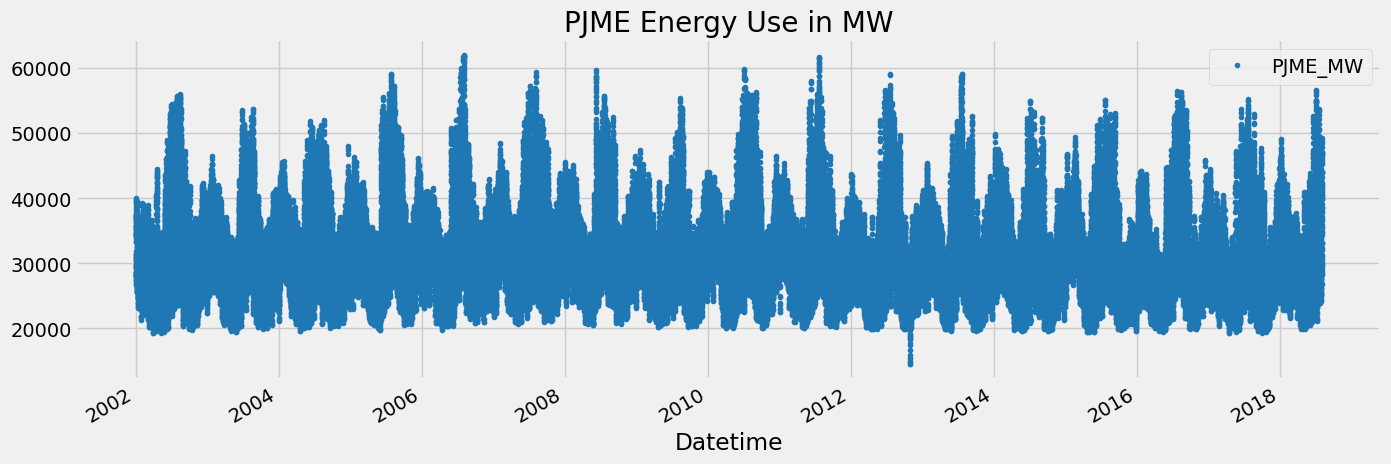

In [6]:
df.plot(style='.', 
        figsize=(15, 5), 
        color=color_pal[0], 
        title='PJME Energy Use in MW')
plt.show()

#### Train/Test Split

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

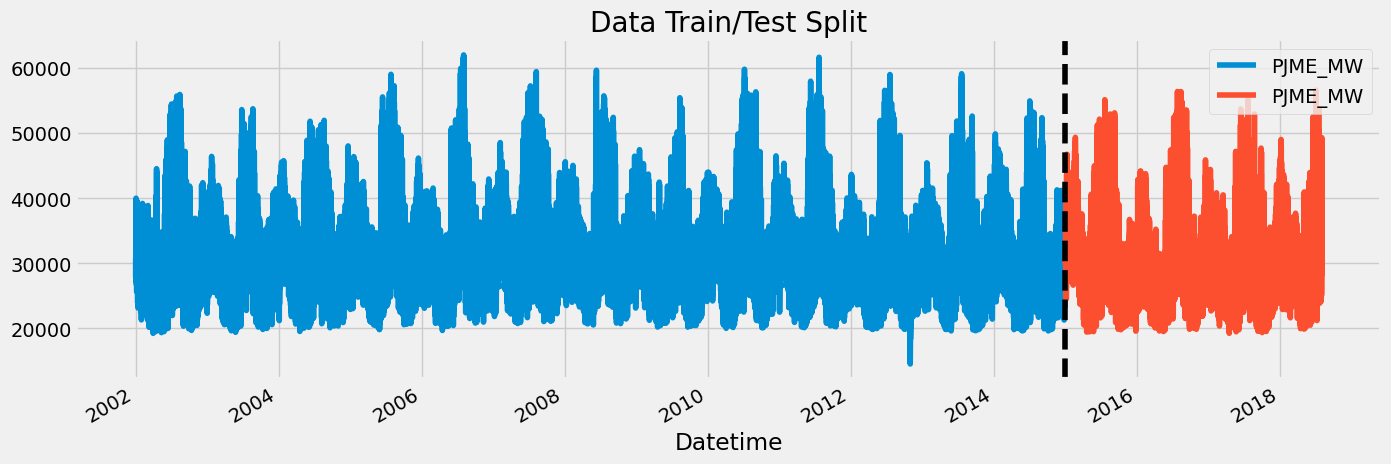

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

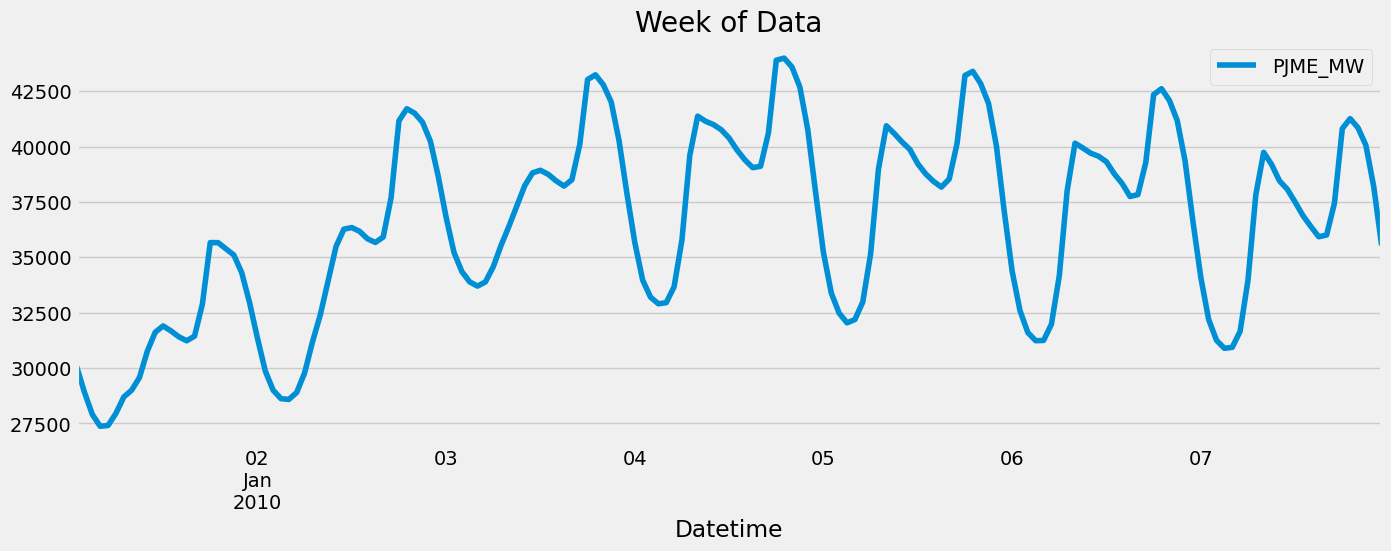

In [9]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].sort_values('Datetime').plot(figsize=(15,5), title='Week of Data')
plt.show()

#### Feature Creation

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [11]:
df = create_features(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


#### Visualize our Feature / Target Relationship

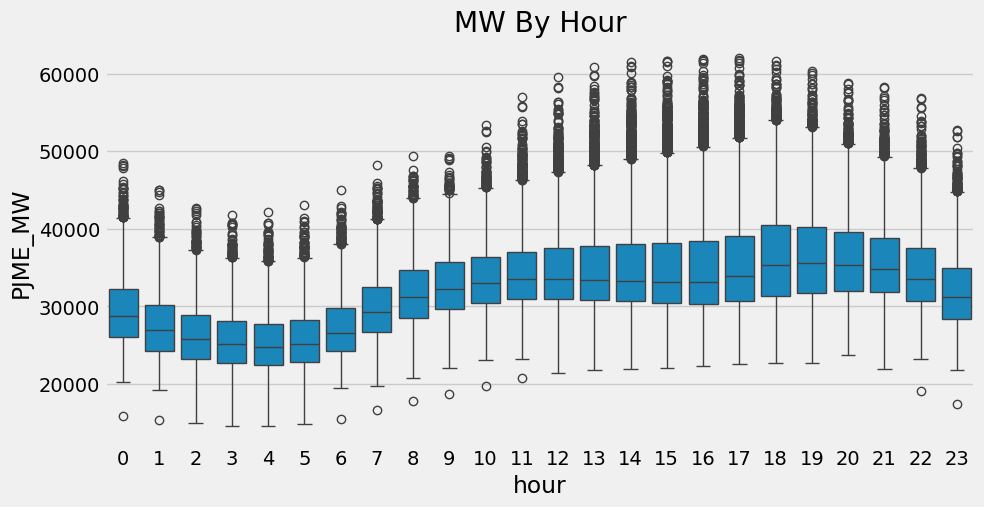

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW By Hour')
plt.show()

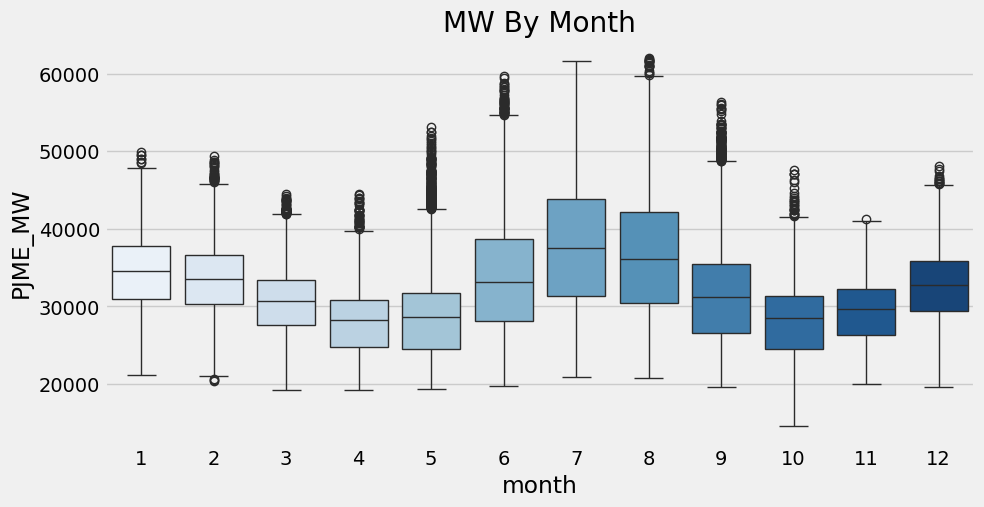

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW By Month')
plt.show()

#### Create Our Model

In [14]:
train = create_features(train)
test = create_features(test)

In [16]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [17]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [18]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50,
                      learning_rate=0.01)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#### Feature Importance

In [24]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
            columns=['importance'])

fi

,importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824
dayofyear,0.118251


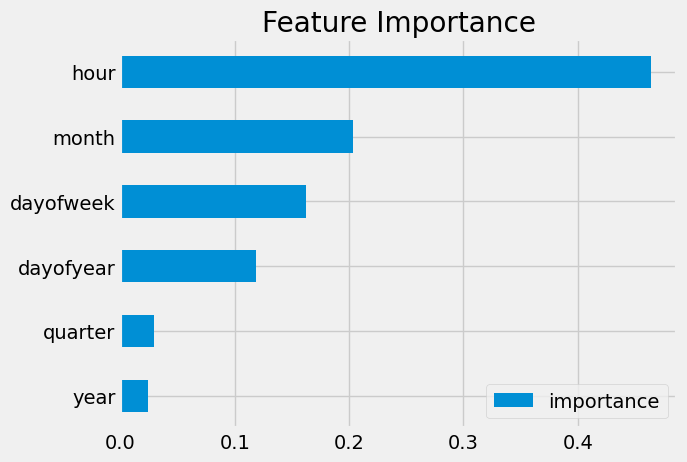

In [25]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Forecast on Test

In [27]:
test['prediction'] = reg.predict(X_test)

In [31]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,NaN
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,38623.246094
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38495.484375
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36229.527344


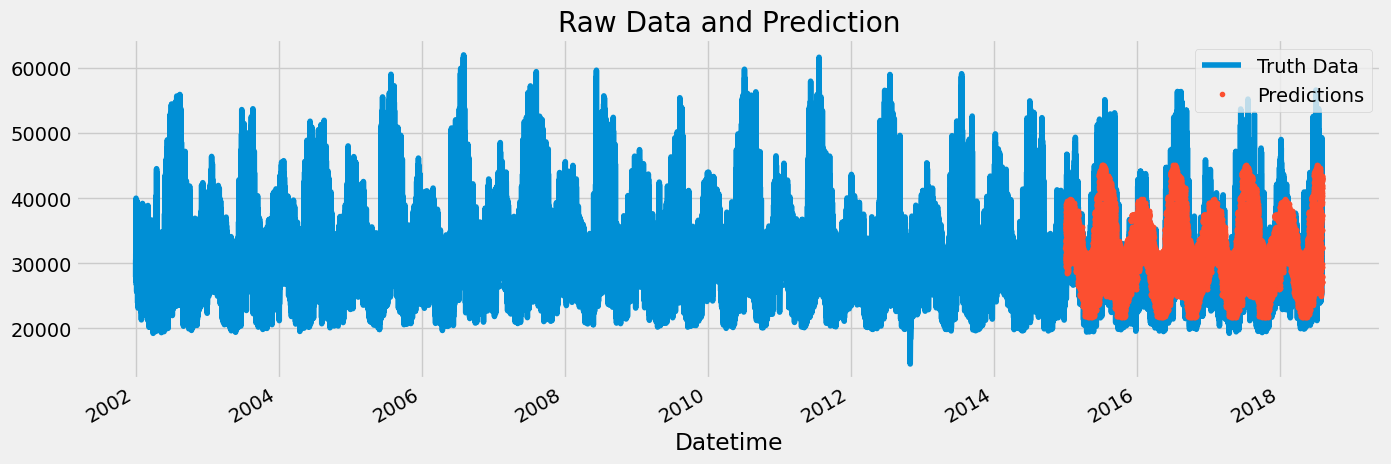

In [33]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

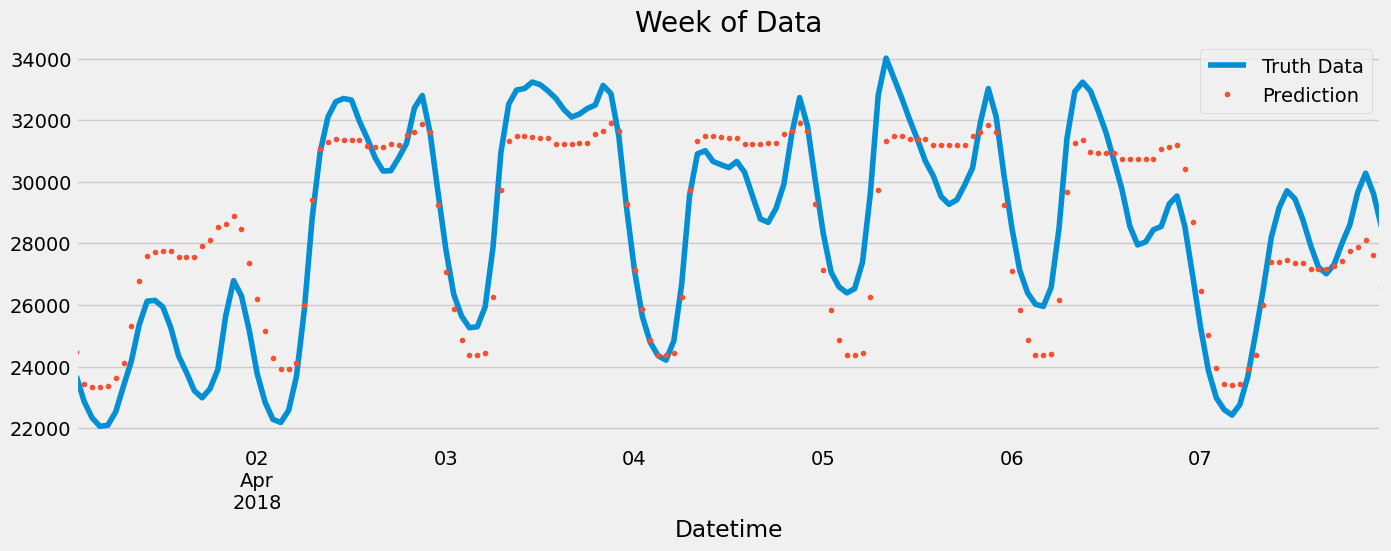

In [35]:
ax = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')].sort_values('Datetime')['PJME_MW'].plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [37]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE Score on Test Set: {score:0.2f}")

RMSE Score on Test Set: 3741.03


#### Calculate Error

- Look at the worst and the best predicted days

In [39]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [41]:
test['date'] = test.index.date

In [43]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()  # Worst Predictions

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [44]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()  # Best Predictions

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64